In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt
import numpy as np

from Load_Data import load_data

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using mps device


# Load Data

In [ ]:
def get_data_loaders(batch_size=64):
    Data = load_data(os.path.join(os.getcwd(), 'Data', 'Parsed_Data'), 
                        train_val_data_to_load=1000, 
                        test_data_to_load=1
                        )
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders()

Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391996.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX1098138.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX391991.faste
Loading coverage from SRX9770785.faste


# Build Model

In [4]:
class DnaCnn(nn.Module):
    def __init__(self, num_kernels=[20, 32, 32], kernel_size=[12,12,12],
                 dropout=0):
        super(DnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[2], num_kernels[2]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),            
            nn.Linear(num_kernels[2], 1)
            #nn.Sigmoid()
        )            

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [5]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer):
    epochs = 50
    loss_fn = nn.PoissonNLLLoss()
    patience = 10
    
    train_loss = []
    validation_loss = []
    best_loss = math.inf
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if loss < best_loss:
            best_loss = loss    
            p = patience
        else:
            p -= 1
            if p == 0:
                print("Early Stopping!")
                break    
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

Epoch 0
-------------------------------
training loss: 163.135529
Validation Loss: 127.512909 

Epoch 10
-------------------------------
training loss: -481.931152
Validation Loss: -742.685303 

Epoch 20
-------------------------------
training loss: -4324.989746
Validation Loss: -6206.182617 

Epoch 30
-------------------------------
training loss: -11583.037109
Validation Loss: -15196.612305 

Early Stopping!
Done!


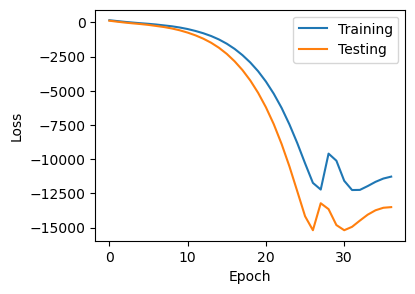

In [6]:
model = DnaCnn().to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(train_loader, val_loader, model, optimizer)

### Save Model

In [7]:
torch.save(model, "model.pth")

### Train Model

In [8]:
model = torch.load("model.pth", weights_only=False)
model.to(device)
model.eval()

DnaCnn(
  (conv_block): Sequential(
    (0): Conv1d(4, 20, kernel_size=(12,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv1d(20, 32, kernel_size=(12,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (5): Sequential(
      (0): Conv1d(32, 32, kernel_size=(12,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
  )
  (regression_block): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)